In [5]:
import pandas as pd, numpy as np, json, datetime

def datetime_str_to_object(fitbit_str):
    """Helper function to convert fitbit datetime str into python datetime object"""
    return datetime.datetime.strptime(fitbit_str, "%Y-%m-%dT%H:%M:%S.000")

def get_heart_rate_data(date):
    """Returns the dictionary of {time, heart_rate} for the given date"""
    times, heart_rates = [], []
    # get heart data from the data file
    with open('data/alta_hr/'+date+'-heart.json') as file:
        data = json.load(file)
        for item in data['activities-heart-intraday']['dataset']:
            times.append(datetime_str_to_object(date+"T"+item['time']+".000"))
            heart_rates.append(item['value'])
            
    return {'time':times, 'heart_rate':heart_rates}

def get_dataframe(date):
    """Returns the df of time(index), heart_rate, sleep_stage, half_mins_passed"""
    # create pandas dataframe from json, resample 30 seconds and write mean(integer) of heart rates
    df = pd.DataFrame(get_heart_rate_data(date)).set_index('time').resample('30s').mean().fillna(0).astype(int)
    df['sleep_stage'] = np.nan # fill sleep_stages with nan values
    
    # get sleep data from the data file
    with open('data/alta_hr/'+date+'-sleep.json') as file:
        data = json.load(file)
        start_time = datetime_str_to_object(data['sleep'][0]['startTime']) # sleep start time
        end_time = datetime_str_to_object(data['sleep'][0]['endTime']) # sleep end time
        for item in data['sleep'][0]['levels']['data']:
            df.loc[datetime_str_to_object(item['dateTime']), 'sleep_stage'] = item['level']
            
    df = df.loc[start_time:end_time,].fillna(method='ffill')
    df['half_mins_passed'] = np.arange(len(df))
    
    return df[['half_mins_passed','heart_rate','sleep_stage']] # correct order

get_dataframe("2019-03-19")



,half_mins_passed,heart_rate,sleep_stage
time,,,
2019-03-19 01:06:00,0,62,wake
2019-03-19 01:06:30,1,60,wake
2019-03-19 01:07:00,2,59,wake
2019-03-19 01:07:30,3,58,wake
2019-03-19 01:08:00,4,61,wake
2019-03-19 01:08:30,5,57,wake
2019-03-19 01:09:00,6,56,wake
2019-03-19 01:09:30,7,59,wake
2019-03-19 01:10:00,8,62,light


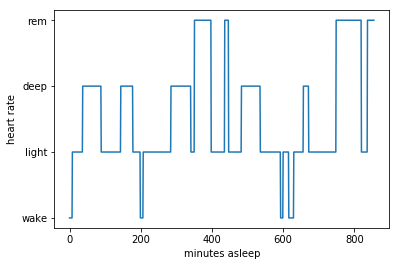

In [19]:
import matplotlib.pyplot as plt

date = "2019-03-19"

df = get_dataframe(date)

plt.ylabel('heart rate')
plt.xlabel('minutes asleep')
# plt.plot(df['half_mins_passed'],df['heart_rate'])
plt.plot(df['half_mins_passed'],df['sleep_stage'])


# plt.scatter(list(df.loc[df['is_awake']==1].index),df['heart_rate'].loc[df['is_awake']==1], c='r')

plt.show()